# Attendance

[The link to SEAts](https://gold.seats.cloud/angular/#/lectures)

---

# 4 Getting started with neural networks:

# Classification and regression

In [1]:
import os
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 2  # nice scatter point size

# matplotlib shenanigans
import matplotlib
plt_fontsize = matplotlib.rcParams["font.size"]

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # mute some annoying warnings

## * Binary classification: data → scalar (probability of *one* class)

*\"Here is a photo, is it a cat or not?" (Negative/Positive, detecting if something is there, etc.)*

#### Multiclass classification: data → vector (distribution over *many classes*)

*\"Here is a photo, multiple choice for you: is it a cat, a dog, an airplane, a flower, ... ?*

#### Regression: data → scalar (a continuous value describing the data)

*\"Here is a data about a house, what is its price)?* <small>☠️☠️☠️ *Logistic regression* (*classification problem*) ≠ *regression*!!</small>

<!-- ![Classification vs regression](images/ml/Classification-vs-Regression.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/3-getting-started/images/ml/Classification-vs-Regression.png?raw=true">

<small>[Sami Belkacem, "Machine learning approaches to rank news feed updates on social media", ResearchGate](https://www.researchgate.net/figure/Classification-vs-Regression_fig2_350993856)</small>

<!-- ![Binary vs multiclass classification](images/ml/Binary-vs-Multiclass-classification.jpg) -->
<img src="https://github.com/jchwenger/AI/blob/main/3-getting-started/images/ml/Binary-vs-Multiclass-classification.jpg?raw=true">

<small>[Nithiyaraj et al., "FPGA Based Real Time Classification With Support Vector Machine", ResearchGate](https://www.researchgate.net/figure/Binary-vs-Multiclass-classification_fig1_342987800)</small>

---

# 4.1 Classifying movie reviews: a binary classification example

### 4.1.1 The IMDB dataset

Two-class, or binary, classification, is a common ML application.

The [International Movie Data Base dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) consists of 50000 highly polarised textual movie reviews.

They are labelled **positive** or **negative**.

Ships with TensorFlow! 25000 training, 25000 testing.

Each set has 50% positive reviews, 50% negative.

### Code: loading the dataset

In [2]:
# download data                            # top 10000 most frequent words only, discard rare words ↓
((train_data, train_labels), (test_data, test_labels)) = tf.keras.datasets.imdb.load_data(num_words=10000)
print(train_data.shape, test_data.shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(25000,) (25000,)


In [3]:
print(train_data[100]) # how a text looks like: a list of numbers!

[1, 13, 244, 6, 87, 337, 7, 628, 2219, 5, 28, 285, 15, 240, 93, 23, 288, 549, 18, 1455, 673, 4, 241, 534, 3635, 8448, 20, 38, 54, 13, 258, 46, 44, 14, 13, 1241, 7258, 12, 5, 5, 51, 9, 14, 45, 6, 762, 7, 2, 1309, 328, 5, 428, 2473, 15, 26, 1292, 5, 3939, 6728, 5, 1960, 279, 13, 92, 124, 803, 52, 21, 279, 14, 9, 43, 6, 762, 7, 595, 15, 16, 2, 23, 4, 1071, 467, 4, 403, 7, 628, 2219, 8, 97, 6, 171, 3596, 99, 387, 72, 97, 12, 788, 15, 13, 161, 459, 44, 4, 3939, 1101, 173, 21, 69, 8, 401, 2, 4, 481, 88, 61, 4731, 238, 28, 32, 11, 32, 14, 9, 6, 545, 1332, 766, 5, 203, 73, 28, 43, 77, 317, 11, 4, 2, 953, 270, 17, 6, 3616, 13, 545, 386, 25, 92, 1142, 129, 278, 23, 14, 241, 46, 7, 158]


In [ ]:
# get words → index
word_index = tf.keras.datasets.imdb.get_word_index()
# reverse: index → word (Python dict comprehension)
reverse_word_index = {value:key for key,value in word_index.items()}

#### A negative review

In [4]:
decoded_review = ' '.join(
    [                                      # get() works like [] but you can set a default
        reverse_word_index.get(i - 3, '?') # value if the key isn't found -3 because the first
        for i in train_data[100]           # three slots in the vocab are 0: "padding",
    ]                                      #                              1: "start of sequence",
)                                          #                              2: "unknown"

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
print(decoded_review)

? i am a great fan of david lynch and have everything that he's made on dvd except for hotel room the 2 hour twin peaks movie so when i found out about this i immediately grabbed it and and what is this it's a bunch of ? drawn black and white cartoons that are loud and foul mouthed and unfunny maybe i don't know what's good but maybe this is just a bunch of crap that was ? on the public under the name of david lynch to make a few bucks too let me make it clear that i didn't care about the foul language part but had to keep ? the sound because my neighbors might have all in all this is a highly disappointing release and may well have just been left in the ? box set as a curiosity i highly recommend you don't spend your money on this 2 out of 10


In [6]:
print(train_labels[100]) # 0: negative

0


#### A positive review

The question marks are in place of words outside the 10000 word dictionary.

In [7]:
# let's try another one
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[83]])
print(decoded_review, '\n\nlabel: ', train_labels[83])

? the biggest reason i had to see this movie was that it stars susan swift an outstanding and all too ? actress time travel movies usually don't interest me and neither do movies about witchcraft but this movie was fascinating and creepy it didn't rely on outrageous special effects and it didn't focus so heavily on the time travel that the viewer gets lost and confused this was a really creative movie kept simple and focused with great acting by all 

label:  1


---

## 4.1.2 Preparing the data

### Workflow

The network requires tensor input, not lists!

1.  Create integer tensors;
2.  **Pad** lists so they have equal length;
3.  Use **multi-hot** encode.

#### Padding

It is very common for our systems only to accept tensors of a fixed length.

Here, the length will be our vocabulary.

In general, what does padding mean?

- add a **filler** (often `0`) before, or after, shorter sequences;
- **truncate** longer sequences.

```python
x = [1,3]
y = [8,5,9,4,6,7]
# max sequence length: 5
padded_before  = [  # all the same length
    [0,0,0,1,3],    # zeros before
    [5,9,4,6,7],
]
padded_after  = [   # all the same length
    [1,3,0,0,0],    # zeros after
    [8,5,9,4,6],
]
```

#### Multi-hot encoding

Same as one-hot, but we allow for **more than a single hot index**.

The total length of the list is the **size of our vocabulary** (10k words).

### Code: preparing the data

In [8]:
# turn our texts into multi-hot encodings
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))     # a matrix of shape len(seq) x vocab, full of zeros
    for i, sequence in enumerate(sequences):            # for each sequence:
        results[i, sequence] = 1.                       # fill the appropriate indices with 1
    return results                                      # note the NumPy magic! `sequence` is an array!
                                                        # acting as the list of all indices where we want 1s

In [9]:
my_sequences = np.array([[3, 5]])
print(my_sequences)
print(vectorize_sequences(my_sequences, dimension=10))

[[3 5]]
[[0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]]


In [10]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32') # convert to float32
y_test = np.asarray(test_labels).astype('float32')

This code one-hot encodes samples and converts the labels to floating point valued tensors

---

## 4.1.3 Building your model

What we have so far: vector samples, scalar labels.

Let's build a small stack of fully connected `relu`-activated layers.

### Code: building the model

In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input((10000,)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # outputs a single number between 0 & 1: a single probability

### Recap: dense layers

`Dense(16, activation='relu')` implements `output = relu(dot(w, input) + b)`.


- This layer transforms an input tensor into a 1D tensor of shape (16,) – a 16-dimensional vector.

- **Representational space** = **(hidden) units/neurons** = **spatial dimensions** = 16.

- Performs a **geometric transformation** resulting in a **point in 16 dimensional space**.

- Because we always process a **batch**, the dimension you'll see will be 2D: (batch_size, 16).

Think: 16 units → 16-dimensional output.

##### For one sample

| parameter |  shape | note |
| --- |  :--- | :--- |
| input| `(1,10000)`  ||
| weights| `(10000, 16)`  ||
| $Wx$| `(1,16)` | `(1,10000)`$\times$`(10000,16)` → `(1,16)` |
| bias|`(1,16)`  | added elementwise |
| output| `(1,16)`  | activation also elementwise |


##### For a mini-batch

| parameter |  shape | note |
| --- |  :--- | :--- |
| input| `(batch_size,10000)`  ||
| weights| `(10000, 16)`  ||
| $Wx$| `(batch_size,16)` | `(batch_size,10000)`$\times$`(10000,16)` → `(batch_size,16)` |
| bias|`(batch_size,16)`  | added elementwise|
| output| `(batch_size,16)`  |  activation also elementwise |


##### Note

- Math: the number of elements in a vector is the **dimension** or **length** of the vector  
- Programming: **dimension** of a tensor, which is the number of **axes** (or the *length* of the *shape*)!

##### Note

A **unit** is a throwback to the days when artificial neural networks were based on biological neural networks.

A unit is the computational analogue of the neuron.

<!-- ![Stanford brain neuron](images/deep/stanford.neuron.brain.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/3-getting-started/images/deep/stanford.neuron.brain.png?raw=true">

<small>Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4</small>

#### How many hidden units?

More hidden units means more complex representations can be learned but:

- the network is computationally more expensive;
- the network might fit the training data too tightly and performance on the test set degrades.  
  (This is called **overfitting**, we are going to talk about that a lot.)

### Loss & optimiser

This is a binary classification problem: positive or negative.

Our network output could a probability, between 0 and 1, and we cut off at 0.5.

The **binary cross-entropy** is the loss that will get you that result.

Optimizer: `RMSprop`, for starters.

#### Binary cross-entropy

We have a label that can be 0 or 1.

We have a network that outputs a probability between 0 and 1.

We want a loss that penalises the network if it predicts 0 instead of 1, and 1 instead of 0.

The math (for reference):

\begin{align*}
\bbox[5px,border:2px solid red]
{
J_{sample} = \color{purple}{- y \log y_{pred}} \color{navy}{- (1 - y) \log (1 - y_{pred})}
}
\end{align*}

- $y$: our **label**, either 0 or 1.  
- $y_{pred}$: our **predictions**: a probability between 0 and 1!  
- smooth & differentiable for SGD. (◕‿◕)

Notice the $y$ and $(1 - y)$?

This means that if $y$ is 0, the left term goes away, and vice-versa if $y$ is 1.

\begin{align*}
& & J_{sample} &= \color{blue}{- y \log y_{pred}} \color{red}{- (1 - y) \log (1 - y_{pred})}\\
\text{case 1:}\ \color{fuchsia}{y = 0} \Rightarrow&& J_{sample} &= \color{red}{-\log(1 - y_{pred})} \\
\text{minimize } J_{sample} \Rightarrow&& &= 0\\
& & & & y_{pred} \rightarrow 0
\end{align*}


\begin{align*}
& & J_{sample} &= \color{red}{- y \log y_{pred}} \color{blue}{- (1 - y) \log (1 - y_{pred})} \\
\text{case 2:}\ \color{fuchsia}{y = 1} \Rightarrow&& J_{sample} &= \color{red}{-\log y_{pred}} \\
\text{minimize } J_{sample} \Rightarrow&& &= 0\\
& & & & y_{pred} \rightarrow 1
\end{align*}  


In [12]:
def plot_binary_crossentropy(figsize=(10,8)):
    preds = np.linspace(0.01, .99, 100)
    matplotlib.rcParams.update({'font.size': plt_fontsize * 1.5}) # bigger font
    f = plt.figure(figsize=figsize)                               # control figure size
    plt.plot(preds, -np.log(preds), label="If truth is 1: -log(x)")
    plt.plot(preds, -np.log(1 - preds), label="If truth is 0: -log(1 - x)")
    plt.text(0.03, 4, "← truth: 1") # -log(x)
    plt.text(0.065, 3.8, "pred: 0")
    plt.text(0.065, 3.55, "BAD!")
    plt.text(0.055, 0.7, "truth: 0")
    plt.text(0.055, 0.5, "pred: 0")
    plt.text(0.02, 0.3, "↓ GOOD!")
    plt.text(0.82, 4, "truth: 0 →") # -log(1-x)
    plt.text(0.82, 3.8, "pred: 1")
    plt.text(0.82, 3.55, "BAD!")
    plt.text(0.88, 0.7, "truth: 1")
    plt.text(0.88, 0.5, "pred: 1")
    plt.text(0.85, 0.3, "↓ GOOD!")
    plt.title("Logistic regression loss")
    plt.xlabel("Predictions")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.show()
    matplotlib.rcParams.update({'font.size': plt_fontsize})

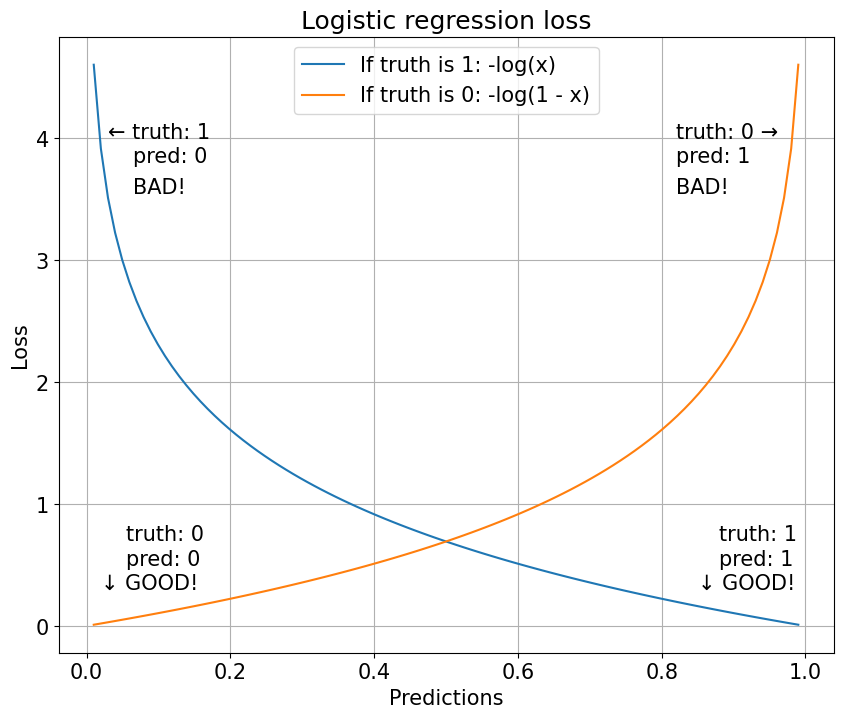

In [13]:
plot_binary_crossentropy()

### Code: compilation

```python
# for more control, we can pass the optimizer as an object! 
# (See: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
model.compile(                                                   
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),  
    loss=tf.keras.losses.binary_crossentropy,                   
    metrics=['accuracy']
)
```

In [14]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Code: Test untrained / commonsense baseline

In [16]:
results = model.evaluate(x_test, y_test, verbose=0) # test our untrained net.

print(f"loss: {results[0]}, accuracy: {results[1]}")

loss: 0.694671630859375, accuracy: 0.48848000168800354


Each set has 50% positive reviews, 50% negative, remember?

In this case, a **commonsense baseline** is just a **random guess**.

A random guess would give you 50%, and we have around 0.5 accuracy.

In [17]:
random_guesses = y_test > 0 # an array of booleans ↔ can be interpreted as 0s and 1s
print(random_guesses.mean(), random_guesses)

0.5 [False  True  True ... False False False]


---

## 4.1.4 Validating your approach

### The problem

We want our model to do well on unseen data. (We use our test set for that.)

To do that, we **tweak** hyperparameters.

For example, experiment with different learning rates.

##### Note

Hyperparameters are all **non-trainable parameters**.  

#### However

If we tweak our parameters and then check the results on our test set...

It's **no longer unseen data**!

**Information** about/from our test set has **leaked** into our training process.

*It's as if we had trained on our test set (a little bit).*

### A solution: validation

We are going to replicate our train/test division **within the training set**.

Training → partial train + validation

<!-- ![training validation test](images/ml/training-validation-test.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/3-getting-started/images/ml/training-validation-test.png?raw=true">

<small>["Training, Validation and Test sets 차이 및 정확한 용도 (훈련, 검정, 테스트 데이터 차이)"](https://modern-manual.tistory.com/m/19)</small>

#### Workflow

1. Train on the **partial training set**;
2. Track performance on the **validation set**;
3. Tweak hyperparameters to get the best result on the **validation set**;
4. Retrain on with best hyperparams on the **whole training set**;
5. Test on **test set**.

<!-- ![training validation test](images/ml/select-best-model.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/3-getting-started/images/ml/select-best-model.png?raw=true">

<small>["Training, Validation and Test sets 차이 및 정확한 용도 (훈련, 검정, 테스트 데이터 차이)"](https://modern-manual.tistory.com/m/19)</small>

### Code: Training

In [18]:
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

x_val = x_train[:10000]
y_val = y_train[:10000]

In [19]:
history = model.fit( # note that a history object is returned by model.fit
    partial_x_train,
    partial_y_train,
    epochs = 20,
    batch_size = 512,
    validation_data = (x_val, y_val)
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.6855 - loss: 0.5836 - val_accuracy: 0.8744 - val_loss: 0.3656
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8976 - loss: 0.3113 - val_accuracy: 0.8735 - val_loss: 0.3195
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9249 - loss: 0.2275 - val_accuracy: 0.8728 - val_loss: 0.3147
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9385 - loss: 0.1881 - val_accuracy: 0.8836 - val_loss: 0.2899
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9489 - loss: 0.1594 - val_accuracy: 0.8859 - val_loss: 0.2796
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9599 - loss: 0.1302 - val_accuracy: 0.8856 - val_loss: 0.2889
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9654 - loss: 0.1143 - val_accuracy: 0.8817 - val_loss: 0.3010
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9767 - loss: 0.0886 - val_accuracy: 0.8772 - 

**Something's going on here: let's plot!**

### Code: plot

`model.fit()` returns a `history` object, as a dictionary.

This contains all the data we asked `compile` to track for us:  

In [20]:
history_dict = history.history
history_dict.keys() # the data gathered during training

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [21]:
history_dict['loss'] # our loss

[0.5004785656929016,
 0.29859665036201477,
 0.2237311452627182,
 0.1857415735721588,
 0.15145409107208252,
 0.1309409737586975,
 0.11594236642122269,
 0.09453413635492325,
 0.08401604741811752,
 0.07414230704307556,
 0.06338927149772644,
 0.053443536162376404,
 0.04709480330348015,
 0.04046303406357765,
 0.03488800302147865,
 0.033478736877441406,
 0.026210207492113113,
 0.02283112332224846,
 0.01897439733147621,
 0.019491294398903847]

In [22]:
def plot_loss():

    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig('overfitting.png', format = 'png')
    plt.show()

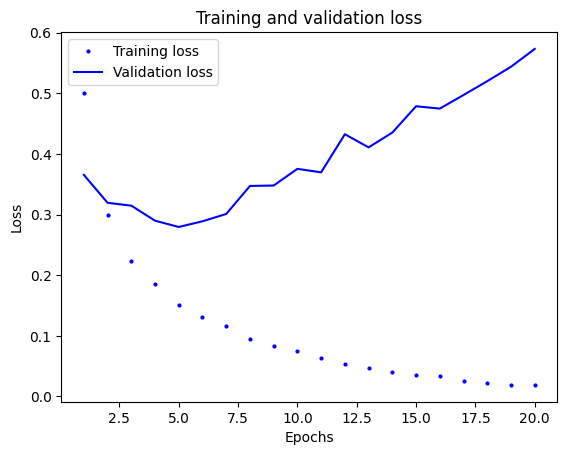

In [23]:
plot_loss() # overfitting!!

In [24]:
def plot_acc():
    plt.clf()
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

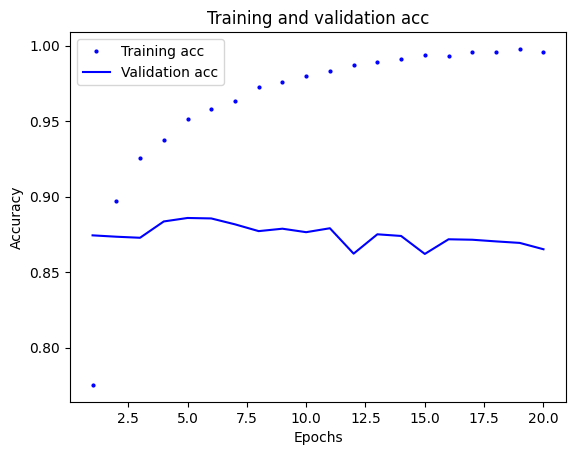

In [25]:
plot_acc() # our model is *very* good on what it has seen, less so on the validation

The model has been 'overtrained' – it fits the training set too closely and begins to fail on unseen data.

The learned representations are too specific.

This is an example of **overfitting**!

### Overfitting

<!-- <img style="height:400px" src="images/overfitting/chollet.overfitting-1.p124.png"> -->
<img src="https://github.com/jchwenger/AI/blob/main/3-getting-started/images/overfitting/chollet.overfitting-1.p124.png?raw=true">

<small>DLWP, p.124</small>

<!-- <img style="height:700px" src="images/overfitting/chollet.overfitting-3.p131.png"> -->
<img style="height:750px" src="https://github.com/jchwenger/AI/blob/main/3-getting-started/images/overfitting/chollet.overfitting-3.p131.png?raw=true">

<small>DLWP, p.131</small>

$$
	\underleftrightarrow{\bf{\text{overfitting} \qquad \qquad \qquad \text{model} \qquad \qquad \text{underfitting}}}\\
$$
$$
    \begin{array}{lcr}
    \text{data point = category} \qquad & \text{data split into categories}  & \qquad \text{dataset = 1 category}\\
    \text{memorising the data} \qquad  &  \text{discriminating model}  &  \qquad \text{indiscriminate/random}\\
    \text{no prediction power} \qquad  &  \text{some predictive power}  &  \qquad \text{trivial predictive power}\\
    \end{array}
$$

#### Intuition 1: recognising people

If you see me today with different clothes or haircut than last week, you may still recognise me.

Even if I change my hair, or perhaps grow a massive beard.

If you **overfitted**, you would have a mental model of me **so precise** that the moment any detail changes you would classify me as an unknown person!

_"JW with this haircut, this jumper and these trousers hasn't been seen before → unknown person."_

In order to recognise people and places we **forget most details** and work with a **model**.

#### Intuition 2: personality type example

$$
	\underleftrightarrow{\bf{\text{overfitting} \qquad \qquad \qquad \text{model} \qquad \qquad \text{underfitting}}}\\
$$
$$
    \begin{array}{lcr}
    \text{everyone is different} \qquad & \text{x personality types}  & \qquad \text{everyone is the same}\\
    \text{sb new? start from zero} \qquad  &  \text{sb new? guess which type}  &  \qquad \text{sb new? type A!}\\
    \end{array}
$$

(If this sounds dystopian, you're on the right track: that's roughly what [social media](https://www.youtube.com/watch?v=nfczi2cI6Cs) is doing.)

### One solution: early stopping

One solution to this is to stop training just as overfitting kicks in.

#### Workflow

- We trained on the **partial training set**;
- We **found the best cut-off epoch** (where overfitting starts);
- We retrain a fresh net on **the full training set** until that number of epochs.

##### Note

We train on the complete training set to give our network as much data as possible for it to perform well.

### Code: automatic best epoch extraction

When did we reach our top `val_accuracy`?

In [26]:
early_stopping_epoch = np.argmax(history.history["val_accuracy"])
print(f"Reached best validation accuracy {history.history['val_accuracy'][early_stopping_epoch]} at epoch {early_stopping_epoch}")

Reached best validation accuracy 0.8859000205993652 at epoch 4


### Code: memory clean-up

Unfortunately, memory management isn't super straightforward, and creating many models in Jupyter will make you run out of memory quite fast!

I'm including code to clear the memory in Jupyter, but even this has some limitations. One thing to consider is to fashion your code so that you can easily restart the kernel and rerun parts of your notebook (while leaving the finished experiments untouched)!

In [27]:
# Memory clean-up for Jupyter
# Slightly modified from fast.ai utils: https://github.com/fastai/course22p2/blob/df9323235bc395b5c2f58a3d08b83761947b9b93/miniai/init.py#L31

import gc
import sys
import time
import traceback

def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    tf.keras.backend.clear_session()
    time.sleep(2)

### Code: Training

In [28]:
clean_mem() # your friend whenever you train many models in a session, this should help with memory use

In [29]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input((10000,)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(16 ,activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(
    x_train,                     # full training set
    y_train,
    epochs=early_stopping_epoch, # the epoch where overfitting starts
    batch_size=512
)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7081 - loss: 0.5845
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8981 - loss: 0.3070
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9212 - loss: 0.2240
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9394 - loss: 0.1799


### Code: evaluate on the test set

In [30]:
results = model.evaluate(x_test, y_test, verbose=0)

print(f"loss: {results[0]}, accuracy: {results[1]}") # accuracy better than before!

loss: 0.30462944507598877, accuracy: 0.8781200051307678


---

## 4.1.5 Using a trained model to generate predictions on new data

Our IMDB network has been trained, we can now use it.

Use `predict` to generate predictions for data.

In [31]:
model.predict(x_test[:10], verbose=0) # this yields probabilities: negative (0) or positive (1) ?

array([[0.28022495],
       [0.99999034],
       [0.9135898 ],
       [0.8789712 ],
       [0.97574186],
       [0.7983047 ],
       [0.9998802 ],
       [0.02089529],
       [0.9838532 ],
       [0.997345  ]], dtype=float32)

In [32]:
def print_predictions(preds, init=0):
    labels = ["negative", "positive"]
    for i, pred in enumerate(preds.ravel()): # ravel() makes the array flat (1D)
        print(f"Review n° {init+i} is {labels[int(pred > .5)]} | score: {pred:.5f}")

In [33]:
print_predictions(model.predict(x_test[:10], verbose=0))

Review n° 0 is negative | score: 0.28022
Review n° 1 is positive | score: 0.99999
Review n° 2 is positive | score: 0.91359
Review n° 3 is positive | score: 0.87897
Review n° 4 is positive | score: 0.97574
Review n° 5 is positive | score: 0.79830
Review n° 6 is positive | score: 0.99988
Review n° 7 is negative | score: 0.02090
Review n° 8 is positive | score: 0.98385
Review n° 9 is positive | score: 0.99734


In [34]:
test_labels[:10] # the first ten labels

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1])

In [35]:
print('review', '\t', 'prediction → rounded', '\t', 'label', '\t', 'correct?')
print()
for i in range(20):
    y_pred = model.predict(x_test[i:i+1], verbose=0)[0][0]
    print(i, '\t', y_pred,'\t', round(y_pred), '\t', test_labels[i], '\t', int(y_pred > .5) == test_labels[i])

review 	 prediction → rounded 	 label 	 correct?

0 	 0.2802249 	 0 	 0 	 True
1 	 0.99999034 	 1 	 1 	 True
2 	 0.9135898 	 1 	 1 	 True
3 	 0.87897116 	 1 	 0 	 False
4 	 0.97574186 	 1 	 1 	 True
5 	 0.7983047 	 1 	 1 	 True
6 	 0.9998802 	 1 	 1 	 True
7 	 0.02089529 	 0 	 0 	 True
8 	 0.9838532 	 1 	 0 	 False
9 	 0.997345 	 1 	 1 	 True
10 	 0.968776 	 1 	 1 	 True
11 	 0.024499564 	 0 	 0 	 True
12 	 0.0007691915 	 0 	 0 	 True
13 	 0.06672748 	 0 	 0 	 True
14 	 0.9993973 	 1 	 1 	 True
15 	 0.0013993097 	 0 	 0 	 True
16 	 0.9635176 	 1 	 1 	 True
17 	 0.7768982 	 1 	 0 	 False
18 	 0.0143851 	 0 	 0 	 True
19 	 0.08091231 	 0 	 0 	 True


In [36]:
# How to use generators in Python: https://realpython.com/introduction-to-python-generators/
def review_finder(prediction, label):
    for i in range(len(x_test)):                                       # looping through our test set
        y_pred = round(model.predict(x_test[i:i+1], verbose=0)[0, 0])  # get prediction
        if y_pred == prediction and test_labels[i] == label:           # if the prediction and the label
            yield i                                                    # are what we are after, yield the index

In [37]:
def print_review(n):
    word_index = tf.keras.datasets.imdb.get_word_index()                                                  # decoding work
    reverse_word_index = {value:key for key,value in word_index.items()}
    decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[n]])

    y_pred = model.predict(x_test[n:n+1], verbose=0)[0,0]                                                 # predict
    print(f"review: {n} | predicted: {y_pred:.6f} | rounded: {round(y_pred)} | label: {test_labels[n]}")  # print
    print()
    print(decoded_review, '\n')

The first successful prediction of a negative review.

In [38]:
neg_neg = review_finder(prediction=0, label=0) # create a generator

In [39]:
print_review(next(neg_neg)) # run again for the next one

review: 0 | predicted: 0.280225 | rounded: 0 | label: 0

? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss 



The first successful positive prediction.

In [40]:
pos_pos = review_finder(prediction=1, label=1) # another generator

In [41]:
print_review(next(pos_pos))

review: 1 | predicted: 0.999990 | rounded: 1 | label: 1

? this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances ? the sandy dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere ? with sexual tension and psychological ? it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by sandy dennis it's definitely one of her darker characters but she plays it so perfectly and convincingly that it's scary michael burns does a good job as the mute young man regular altman player michael murphy has a small part the ? moody set fits the content of the story very well in short this movie is a powerful study of loneliness sexual ? and de

The network predicted negative but the actual label is positive. What do you think?

In [42]:
neg_pos = review_finder(prediction=0, label=1)

In [43]:
print_review(next(neg_pos))

review: 22 | predicted: 0.419362 | rounded: 0 | label: 1

? how managed to avoid attention remains a mystery a potent mix of comedy and crime this one takes chances where tarantino plays it safe with the hollywood formula the risks don't always pay off one character in one sequence comes off ? silly and falls flat in the lead role thomas jane gives a wonderful and complex performance and two brief appearances by mickey rourke hint at the high potential of this much under and ? used actor here's a director one should keep one's eye on 



And the reviews wronglyc classed as positive.

In [44]:
pos_neg = review_finder(prediction=1, label=0)

In [45]:
print_review(next(pos_neg))

review: 3 | predicted: 0.878971 | rounded: 1 | label: 0

? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are ? involved with the actions on the screen so then why the hell can't we have night vision 



---

## Hyperparameter tuning: three ideas

### 1.  Grid search

Systematically try the range of your parameter.

Example: learning rate, best model in bold, we then search around the best parameter...

| **first pass** | **second pass** | **third pass** |
| ---            | ---             | ---            |
| .001           | .0037           | .00377         |
| .002           | **.0038**       | .00378         |
| .003           | .0039           | .00379         |
| **.004**       | .0040           | .00380         |
| .005           | .0041           | .00381         |
| .006           | .0042           | .00382         |
| .007           | .0043           | **.00383**     |

### 2.  Random search

Given that you want to optimize **many** hyperparmeters at the same time, it [has been argued](https://cs231n.github.io/neural-networks-3/#hyper) that grid search is not only infeasible with many params, but also less successful than random search!

#### Workflow

- Determine a range for each hyperparameter;
- Use a random generator to create numbers within this range;
- Try a number of different models, pick the best one.

Document the methodology and list the hyperparameters that were tried!

#### Example

You want to try different momentums, between let's say between .9, and .999.

```python
momentum = 0.9 + np.random.uniform()/10 # a random number between 0. and 0.01
```

You would do the same for a few other hyperparameters.

Make sure to document the process of randomisation and the parameters that have been tried!

Also: you may want to start with this then try and go back to grid search and try further.

### 3.  Babysitting

This could seem clunky, but is what happens with [LARGE models](https://github.com/facebookresearch/metaseq/blob/main/projects/OPT/chronicles/) (← check the logbooks (╯✧▽✧)╯).

#### Workflow

1. Start training for some epochs, look at how your network is doing;
2. Save your net, and **document** the parameters, epoch, etc.
3. Think about what hyperparameters to change next, if any;
4. Keep training;
5. If the result is good, **document** & go back to 3 (save); if not, **document** & go back to 2 (retry)!


Make sure to **document** every stage of the process of tuning!  

Ideally, **someone else should be able to reproduce your results**.

### Note: reproducible results in TF?

Pure TF:

```python
import tensorflow as tf
tf.random.set_seed(42) # can be any number
```
Keras ([source](https://keras.io/examples/keras_recipes/reproducibility_recipes/)):
```python
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()
```

In NumPy & the `random` Python package:
```python
import random
random.seed(42)

import numpy as np
np.random.seed(42)
```

---

## 4.1.6 Further experiments

## 4.1.7 Wrapping up

### Workflow

1. Prepare the data & split into Train/Validation/Test
2. Define your model
3. Evaluate your untrained model / a **commonsense baseline**
4. Train using **Train/Validation**
5. Tweak **hyperparameters** → pick best validation results
6. Retrain on **whole train dataset**
7. Evaluate on **Test**

### Summary

#### Inputs

- Sequences of words often encoded as *binary vectors*;
- Processing inputs as *multi-hot* (similar to *one-hot*);

#### Labels

- Our labels are just integers (0 or 1);

#### Key ideas

- Train/Validation/Test splits;
- Overfitting;
- Commonsense baselines;

### Binary classification
  

- Used for 0/1, true/false problems (two classes: **binary**);
- The final layer is a single dense **sigmoid** unit;
- The loss function is `binary_crossentropy`;
- The model outputs a **one probability**.

### Experiments

- More or fewer hidden layers, with less/more units;
- Try different learning rates and batch sizes;
- Replace `relu` with an early neural network favourite, `tanh`;
- Try the [`Adam` optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers#classes_2): `optimizers.Adam(learning_rate=0.001)`, with various learning rates.
- Try and think about how you would go about automating hyperparameter search (= making your life easier, so that the search is done by a system rather than manually)